In [1]:
import git
git.Repo.clone_from('https://github.com/MorningStarTM/lung-cancer-classification.git', '/kaggle/working/sample')

<git.repo.base.Repo '/kaggle/working/sample/.git'>

In [70]:
import shutil
shutil.rmtree("/kaggle/working/sample")

In [ ]:
!pip install tensorflow==2.10.1

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import itertools
import tensorflow as tf
from matplotlib import gridspec
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix

In [3]:
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['patch_size'] = 64
hp['num_patches'] = (hp['image_size']**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp['patch_size']*hp['patch_size']*hp["num_channels"])
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 3
hp["num_layers"] = 12
hp["hidden_dim"] = 256
hp["mlp_dim"] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1
hp['class_names'] = ["lung_aca", "lung_n", "lung_scc"]

In [4]:
train_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/*"
valid_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Val/*"
test_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Test/*"

model_path = "/kaggle/working/ViT_for_lung_cancer_classification_v3.h5"
csv_path = "/kaggle/working/ViT_for_lung_cancer_classification_v3.csv"

# Helper Function

In [5]:
def get_mean_and_std(x):
    x_mean, x_std = cv2.meanStdDev(x)
    x_mean = np.hstack(np.round(x_mean, 2))
    x_std = np.hstack(np.round(x_std, 2))
    return x_mean, x_std

In [6]:
def apply_mean_std(input_img, temaplate_mean, temaplate_std):
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2LAB)

    img_mean, img_std = get_mean_and_std(input_img)
    h, w, c = input_img.shape
    for i in range(0, h):
        for j in range(0, w):
            for k in range(0, c):
                x = input_img[i,j,k]
                x = ((x-img_mean[k]) * (temaplate_std[k] / img_std[k])) + temaplate_mean[k]
                x = round(x)
                x = 0 if x<0 else x
                x = 255 if x>255 else x
                input_img[i,j,k] = x

    input_img = cv2.cvtColor(input_img, cv2.COLOR_LAB2BGR)
    return input_img

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*.jpeg")))
    return images

In [9]:
def process_image(path, temaplate_mean, temaplate_std):
    #decode the path
    #path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [512, 512])
    image = apply_mean_std(image, temaplate_mean, temaplate_std)
    
    #scale the image
    #image = image / 255.0
    #change the data type of image
    #image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = hp['class_names'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

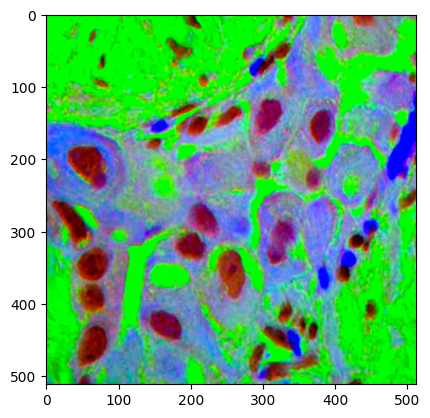

In [10]:
path_temp = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_aca/lungaca1.jpeg"
img = cv2.imread(path_temp)
template = cv2.imread("/kaggle/working/sample/stain/temp_5.jpg", cv2.IMREAD_ANYCOLOR)
temaplate_mean, temaplate_std = get_mean_and_std(template)
image, class_idx = process_image(path_temp, temaplate_mean, temaplate_std)
plt.imshow(image)

In [11]:
def tf_dataset(images, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse)
    ds = ds.batch(32).prefetch(8)
    return ds

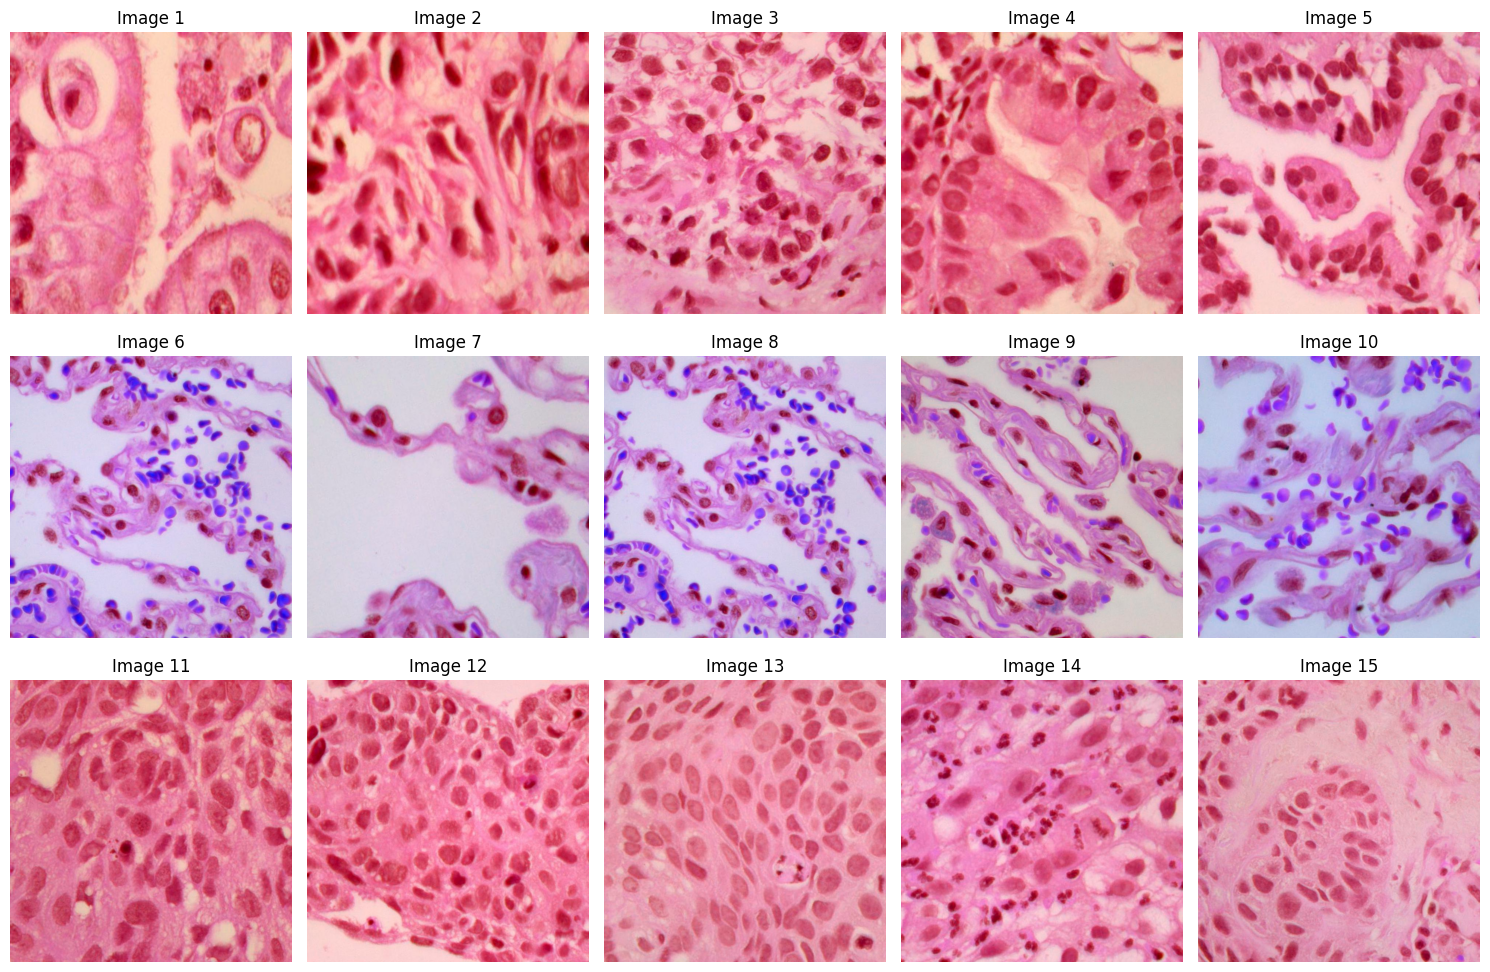

In [12]:
aca_dir = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_aca/"
n_dir = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_n/"
scc_dir = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_scc/"

aca_imgs = os.listdir(aca_dir)[0:5]
n_imgs = os.listdir(n_dir)[0:5]
scc_imgs = os.listdir(scc_dir)[0:5]

aca_imgs = [aca_dir + file for file in aca_imgs]
n_imgs = [n_dir + file for file in n_imgs]
scc_imgs = [scc_dir + file for file in scc_imgs]

images_list = aca_imgs + n_imgs + scc_imgs

# Create a 5x3 subplot grid
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# Iterate through the list of image files and plot them
for i, ax in enumerate(axes.flat):
    if i < len(images_list):
        img = cv2.imread(images_list[i], cv2.IMREAD_COLOR)
        ax.imshow(img)
        ax.set_title(f"Image {i+1}")
        ax.axis("off")  # Turn off axis labels

# Remove any empty subplots
for i in range(len(images_list), 15):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

# Stain Normalization

In [13]:
def get_mean_and_std(x):
    x_mean, x_std = cv2.meanStdDev(x)
    x_mean = np.hstack(np.round(x_mean, 2))
    x_std = np.hstack(np.round(x_std, 2))
    return x_mean, x_std

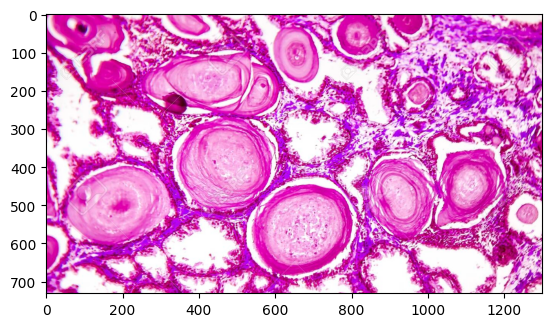

In [14]:
temaplate = cv2.imread("/kaggle/working/sample/stain/temp_2.jpg")
temaplate_img = cv2.cvtColor(temaplate, cv2.COLOR_BGR2LAB)
temaplate_mean, temaplate_std = get_mean_and_std(temaplate_img)
plt.imshow(temaplate)

In [15]:
create_dir("/kaggle/working/stain_normalized/lung_aca")
create_dir("/kaggle/working/stain_normalized/lung_n")
create_dir("/kaggle/working/stain_normalized/lung_scc")

In [16]:
aca_image_list = os.listdir(aca_dir)
len(aca_image_list)

3750

In [ ]:
for img in (aca_image_list):
    print(img)
    input_img = cv2.imread(aca_dir+img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2LAB)

    img_mean, img_std = get_mean_and_std(input_img)

    h, w, c = input_img.shape
    for i in range(0, h):
        for j in range(0, w):
            for k in range(0, c):
                x = input_img[i,j,k]
                x = ((x-img_mean[k]) * (temaplate_std[k] / img_std[k])) + temaplate_mean[k]
                x = round(x)
                x = 0 if x<0 else x
                x = 255 if x>255 else x
                input_img[i,j,k] = x

    input_img = cv2.cvtColor(input_img, cv2.COLOR_LAB2BGR)
    cv2.imwrite(f"/kaggle/working/stain_normalized/lung_aca/Modified_{img}", input_img)

lungaca2056.jpeg
lungaca1914.jpeg
lungaca861.jpeg
lungaca918.jpeg
lungaca452.jpeg
lungaca2826.jpeg
lungaca2491.jpeg
lungaca3577.jpeg
lungaca2818.jpeg
lungaca224.jpeg
lungaca2906.jpeg
lungaca2822.jpeg
lungaca312.jpeg
lungaca702.jpeg
lungaca81.jpeg
lungaca1300.jpeg
lungaca677.jpeg
lungaca1596.jpeg
lungaca2288.jpeg
lungaca1058.jpeg
lungaca2040.jpeg
lungaca1572.jpeg
lungaca2218.jpeg
lungaca3679.jpeg
lungaca94.jpeg
lungaca2503.jpeg
lungaca2074.jpeg
lungaca1389.jpeg
lungaca3163.jpeg
lungaca1929.jpeg
lungaca2295.jpeg
lungaca1100.jpeg
lungaca1531.jpeg
lungaca2605.jpeg
lungaca789.jpeg
lungaca607.jpeg
lungaca1561.jpeg
lungaca2698.jpeg
lungaca1637.jpeg
lungaca3698.jpeg
lungaca3189.jpeg
lungaca223.jpeg
lungaca3340.jpeg
lungaca381.jpeg
lungaca220.jpeg
lungaca2298.jpeg
lungaca3348.jpeg
lungaca3093.jpeg
lungaca1804.jpeg
lungaca3085.jpeg
lungaca1204.jpeg
lungaca2587.jpeg
lungaca179.jpeg
lungaca1316.jpeg
lungaca3258.jpeg
lungaca1093.jpeg
lungaca3674.jpeg
lungaca3016.jpeg
lungaca1603.jpeg
lungaca2018.jp

In [34]:
ou = "/kaggle/working/stain_normalized/lung_aca"
ou + "mod"

'/kaggle/working/stain_normalized/lung_acamod'

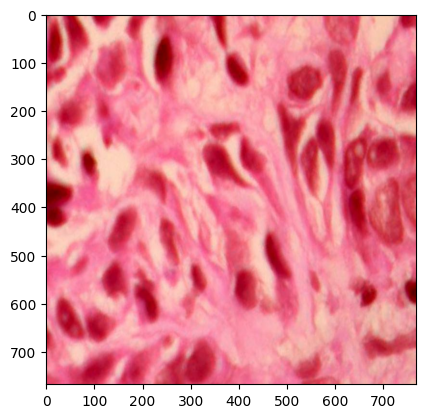

In [24]:
aca = cv2.imread("/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/lung_aca/lungaca1914.jpeg")
plt.imshow(aca)